<a href="https://colab.research.google.com/github/swilsonmfc/anomaly/blob/master/AnomalyTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Time Series
![alt text](https://miro.medium.com/max/1383/0*yRqQyhyMQIQ2W8Gv)

# Setup

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 17.9MB/s 
     |████████████████████████████████| 8.7MB 29.7MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install ruptures

  Created wheel for ruptures: filename=ruptures-1.0.3-cp36-none-any.whl size=55251 sha256=8f9597f75eb674249524b40e53c0fe952ad8eceb8ab59a1c42f7d0d658682afb
  Stored in directory: /root/.cache/pip/wheels/8b/a2/15/6e7b600d1415d6d3e746e3004dc23eef3bf7778d35e6afebac
Successfully built ruptures


In [ ]:
pip install tsaug 

     |████████████████████████████████| 92kB 4.0MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=17b00309781d864102ec063b43f1b2995ae0c8912ecb1299378e46c9f259a413
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from pmdarima.utils import tsdisplay

import ruptures as rpt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interactive

from tsaug import Drift
from tsaug import TimeWarp
from tsaug import Reverse
from tsaug import AddNoise

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

# Data

In [ ]:
!git clone https://github.com/swilsonmfc/anomaly

Cloning into 'anomaly'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 18), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [ ]:
cd anomaly

/content/anomaly


In [ ]:
ls data

data_anomaly_ecoli.csv         data_anomaly_shuttle_train.csv
data_anomaly_shuttle.csv       data_anomaly_speech.csv
data_anomaly_shuttle_test.csv  data_anomaly_taxi.csv


In [ ]:
taxi_df = pd.read_csv('data/data_anomaly_taxi.csv')

# EDA

In [ ]:
taxi_df.head()

,TIMESTAMP,VALUE,OUTLIER
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


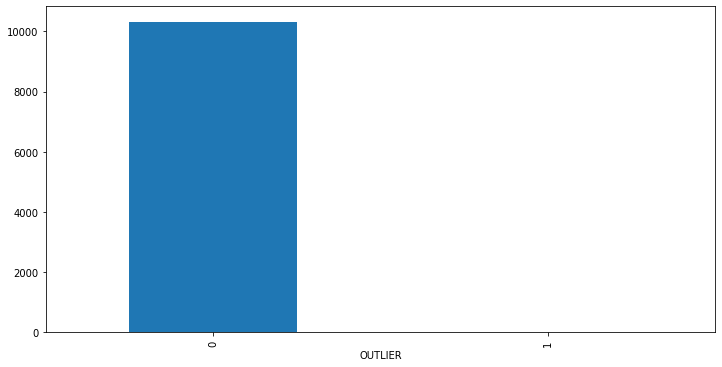

In [ ]:
taxi_df.groupby('OUTLIER').size().plot.bar()

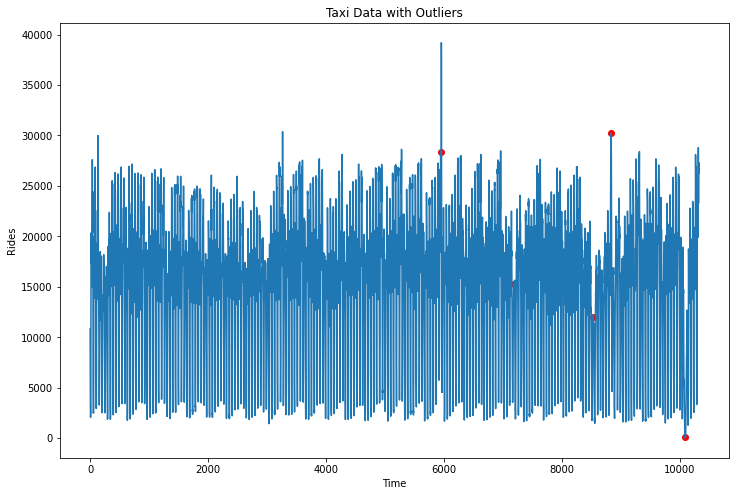

In [ ]:
taxi_df['VALUE'].plot(figsize=(12,8))
outliers_df = taxi_df[taxi_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

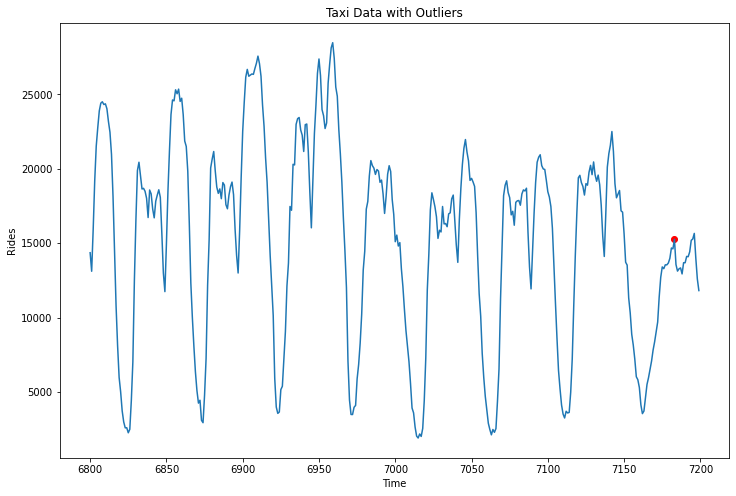

In [ ]:
subset_df = taxi_df[6800:7200]
subset_df['VALUE'].plot(figsize=(12,8))
outliers_df = subset_df[subset_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

# Helpers

In [ ]:
def plot_outliers(X, test, pred):
  df = X.copy()
  df['OUTLIER'] = test
  df['PRED']    = pred
  df = df.reset_index()

  df['VALUE'].plot(figsize=(12,8))

  outliers_df = df[df.OUTLIER == 1]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
  outliers_df = df[(df.OUTLIER == 0) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red', marker='x') 
  outliers_df = df[(df.OUTLIER == 1) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='green');
  
  plt.xlabel('Time')
  plt.ylabel('Rides')
  plt.title('Taxi Data with Outliers');

def evaluate_outliers(X, y, pred):
  plot_outliers(X, y, pred)
  plot_confusion(y, pred)
  print_classification_report(y, pred)

def print_classification_report(test, pred, target_names=['NORMAL', 'OUTLIER']):
  report = classification_report(test, pred, target_names=target_names)
  print(report)  

def plot_confusion(test, pred, class_names=['NORMAL', 'OUTLIER']):
  cm = confusion_matrix(test, pred)
  df = pd.DataFrame(cm, class_names, class_names)
  plt.figure(figsize=(10, 10))
  sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

def plot_roc_curve(test, pred_proba):
  fpr, tpr, _ = roc_curve(test,  pred_proba)
  auc = roc_auc_score(test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(fpr, tpr, label=f'AUC = {auc}')
  plt.plot([0,1], [0,1], linestyle='--')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plot_precision_recall_curve(test, pred_proba):
  precision, recall, _ = precision_recall_curve(test, pred_proba)
  aps = average_precision_score(y_test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(recall, precision, label=f'Avg Precision = {aps}')
  plt.plot([0,1], [0.5,0.5], linestyle='--')
  plt.fill_between(recall, 0, precision)
  plt.title('Precision Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc=4)
  plt.show()

# Preprocessing

In [ ]:
X_train = taxi_df.copy()
y_train = X_train['OUTLIER'].copy()
X_train = X_train.drop(columns=['TIMESTAMP', 'OUTLIER'])

## Missing Data

# Evaluation Metrics
## Regression
![alt text](https://1.bp.blogspot.com/-kL42RjXdOEc/XMELxXVMe3I/AAAAAAAABRw/mx2RoIheodwWj0CPAqg9chwXJmpOyPyJQCLcBGAs/s1600/Loss_Functions.PNG)

## Classification
* Accuracy
* Precision
* Recall

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

# Time Series
* Probablitic Techniques
  * Advantages
    * Easy to implement
    * Can "approximate" changing conditions
  * Disadvantages
    * Struggle with cutoff
    * Trend is a problem 
    * Seasonality is problematic
* Can we use time series techniques to help?
  * Decompose a time series into 
    * Trend
    * Seasonality
    * Noise
  * Anomalies score high on "noise"


# Seasonal Decomposition
* Time Series can be broken down into:
  * Trend
  * Seasonality
  * Residual
* Large residual suggests anomalies

In [ ]:
seadecomp_df = taxi_df.copy()
seadecomp_df = seadecomp_df[['TIMESTAMP', 'VALUE']]
seadecomp_df['TIMESTAMP'] = pd.to_datetime(seadecomp_df.TIMESTAMP)
seadecomp_df = seadecomp_df.set_index('TIMESTAMP')
seadecomp_df = seadecomp_df.asfreq('30T')
seadecomp_df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=10320, freq='30T')

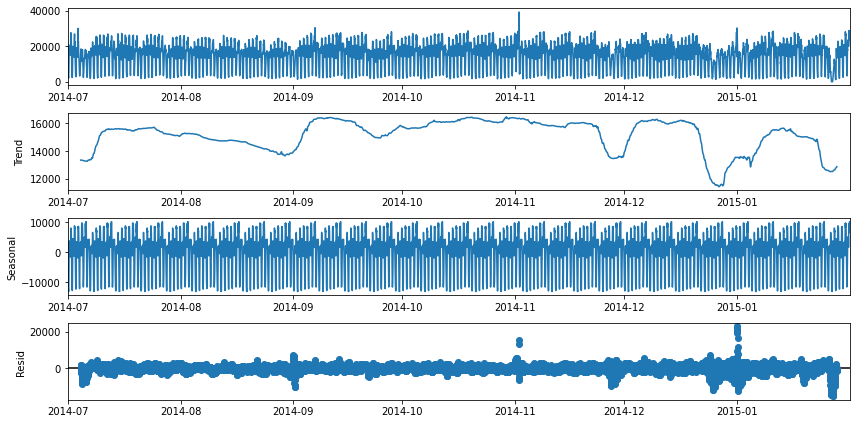

In [ ]:
additive = seasonal_decompose(seadecomp_df, model='additive', period=48 * 7)
additive.plot();

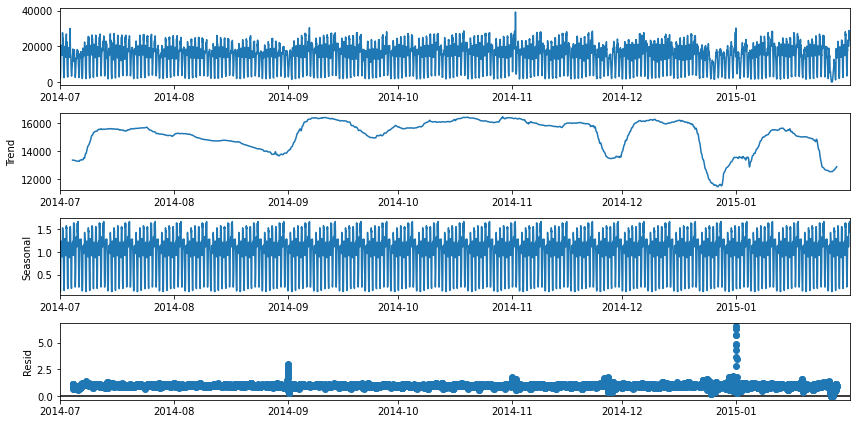

In [ ]:
multiplicative = seasonal_decompose(seadecomp_df, model='multiplicative', period=48 * 7)
multiplicative.plot();

# Simple Exponential Smoothing
* Future values are influenced by past values

## Data Prep

In [ ]:
ses_df = taxi_df.copy()
ses_df = ses_df[['TIMESTAMP', 'VALUE']]
ses_df['TIMESTAMP'] = pd.to_datetime(ses_df.TIMESTAMP)
ses_df = ses_df.set_index('TIMESTAMP')
ses_df = ses_df.asfreq('30T')
ses_df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=10320, freq='30T')

## Visualize
* Alpha is the coefficient of smoothing
* When alpha = 0, we see historical average
* When alpha = 1, we get a naive model (predict last value)

In [ ]:
@interact
def visualize_smoothing(alpha=0.):
  df = ses_df[['VALUE']]
  ses = SimpleExpSmoothing(df).fit(smoothing_level=alpha, optimized=False) 
  plt.figure(figsize=(10, 8))
  plt.plot(df, label='Data')
  plt.plot(ses.fittedvalues, color='orange', label='SES')
  plt.xlim(pd.Timestamp('2014-11-01'), pd.Timestamp('2014-11-03'))
  plt.legend()
  plt.title('Simple Exponential Smoothing')

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

## Model

In [ ]:
SMOOTHING=0.5
model_smoothing = SimpleExpSmoothing(ses_df).fit(smoothing_level=SMOOTHING, optimized=False)
model_smoothing.summary()

Dep. Variable:,endog,No. Observations:,10320
Model:,SimpleExpSmoothing,SSE,77168472211.130
Optimized:,False,AIC,163342.951
Trend:,None,BIC,163357.435
Seasonal:,None,AICC,163342.955
Seasonal Periods:,None,Date:,"Tue, 21 Jul 2020"
Box-Cox:,False,Time:,15:55:49
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,10844.000,l.0,False


Text(0.5, 1.0, 'Simple Exponential Smoothing')

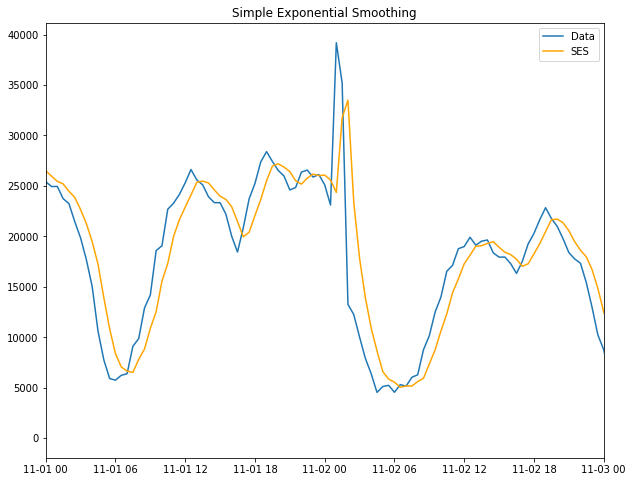

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(ses_df, label='Data')
plt.plot(model_smoothing.fittedvalues, color='orange', label='SES')
plt.xlim(pd.Timestamp('2014-11-01'), pd.Timestamp('2014-11-03'))
plt.legend()
plt.title('Simple Exponential Smoothing')

## Test

In [ ]:
start_index = 0
end_index   = len(ses_df)
forecast    = model_smoothing.predict(start=start_index, end=end_index)
ses_df['PREDICTED'] = forecast
ses_df['ERROR']     = ses_df.PREDICTED - ses_df.VALUE
deviation           = ses_df.ERROR.std()
ses_df['LOWER']     = ses_df.PREDICTED - (1.96 * deviation)
ses_df['UPPER']     = ses_df.PREDICTED + (1.96 * deviation)
ses_df['OUTLIER']   = taxi_df['OUTLIER'].values
ses_df['PRED']      = np.where((ses_df.VALUE >= ses_df.LOWER) &
                                   (ses_df.VALUE <= ses_df.UPPER), 0, 1)

In [ ]:
ses_df.head()

,VALUE,PREDICTED,ERROR,LOWER,UPPER,OUTLIER,PRED
TIMESTAMP,,,,,,,
2014-07-01 00:00:00,10844,10844.000,0.000,5484.096703,16203.903297,0,0
2014-07-01 00:30:00,8127,10844.000,2717.000,5484.096703,16203.903297,0,0
2014-07-01 01:00:00,6210,9485.500,3275.500,4125.596703,14845.403297,0,0
2014-07-01 01:30:00,4656,7847.750,3191.750,2487.846703,13207.653297,0,0
2014-07-01 02:00:00,3820,6251.875,2431.875,891.971703,11611.778297,0,0


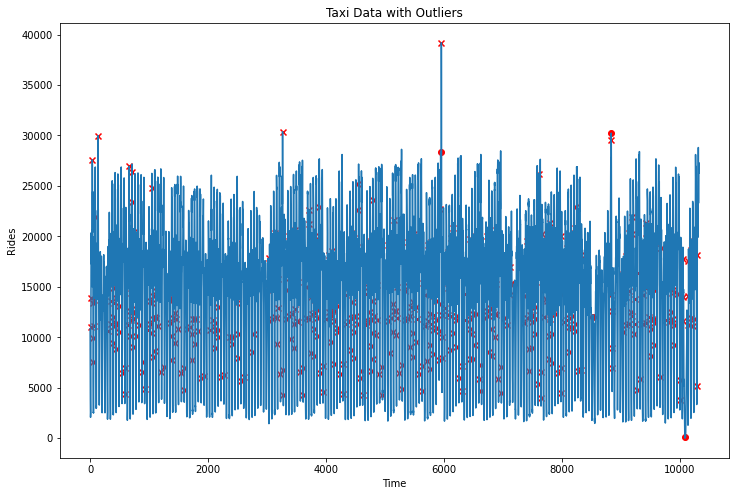

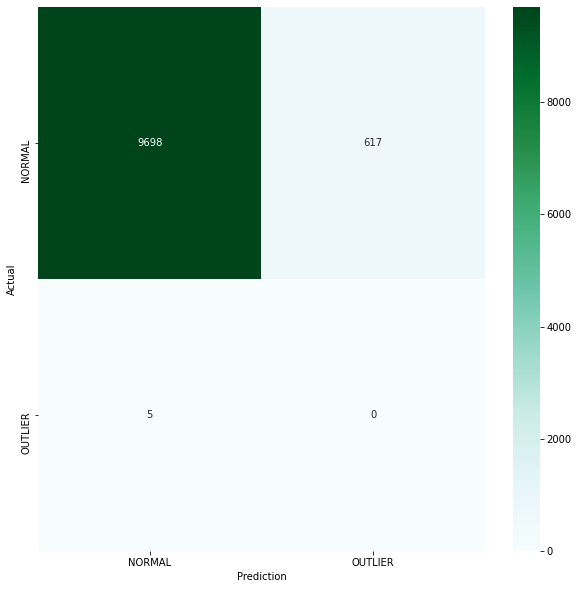

              precision    recall  f1-score   support

      NORMAL       1.00      0.94      0.97     10315
     OUTLIER       0.00      0.00      0.00         5

    accuracy                           0.94     10320
   macro avg       0.50      0.47      0.48     10320
weighted avg       1.00      0.94      0.97     10320



In [ ]:
evaluate_outliers(ses_df, ses_df['OUTLIER'], ses_df['PRED'])

## Predict

In [ ]:
model_smoothing.forecast(steps=1)

2015-02-01    26341.512718
Freq: 30T, dtype: float64

# Holt Winters
* Often called triple exponential smoothing
* Increase model complexity allowing for:
  * Level
  * Trend
  * Seasonality

## Data Prep

In [ ]:
tes_df = taxi_df.copy()
tes_df = tes_df[['TIMESTAMP', 'VALUE']]
tes_df['TIMESTAMP'] = pd.to_datetime(tes_df.TIMESTAMP)
tes_df = tes_df.set_index('TIMESTAMP')
tes_df = tes_df.asfreq('30T')
tes_df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=10320, freq='30T')

## Visualize

In [ ]:
@interact
def visualize_triple_smoothing(alpha=0., beta=0., trend=['multiplicative', 'additive']):
  df = tes_df[['VALUE']]
  tes = ExponentialSmoothing(df, trend=trend).fit(smoothing_level=alpha, 
                                                  smoothing_slope=beta,
                                                  optimized=False) 
  plt.figure(figsize=(10, 8))
  plt.plot(df, label='Data')
  plt.plot(tes.fittedvalues, color='orange', label='TES')
  plt.xlim(pd.Timestamp('2014-11-01'), pd.Timestamp('2014-11-03'))
  plt.legend()
  plt.title('Triple Exponential Smoothing')

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), FloatSlider(value=0.0, description…

## Model

In [ ]:
model_tes = ExponentialSmoothing(tes_df, 
                                 trend='additive', 
                                 seasonal='additive', 
                                 seasonal_periods = 48).fit()
model_tes.summary()

Dep. Variable:,endog,No. Observations:,10320
Model:,ExponentialSmoothing,SSE,17633455098.214
Optimized:,True,AIC,148208.639
Trend:,Additive,BIC,148585.215
Seasonal:,Additive,AICC,148209.218
Seasonal Periods:,48,Date:,"Tue, 21 Jul 2020"
Box-Cox:,False,Time:,15:55:51
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9473687,alpha,True
smoothing_slope,0.0526313,beta,True


## Test

In [ ]:
start_index = 0
end_index   = len(tes_df)
forecast    = model_tes.predict(start=start_index, end=end_index)
tes_df['PREDICTED'] = forecast
tes_df['ERROR']     = tes_df.PREDICTED - tes_df.VALUE
deviation           = tes_df.ERROR.std()
tes_df['LOWER']     = tes_df.PREDICTED - (1.96 * deviation)
tes_df['UPPER']     = tes_df.PREDICTED + (1.96 * deviation)
tes_df['OUTLIER']   = taxi_df['OUTLIER'].values
tes_df['PRED']      = np.where((tes_df.VALUE >= tes_df.LOWER) &
                                   (tes_df.VALUE <= tes_df.UPPER), 0, 1)

In [ ]:
tes_df

,VALUE,PREDICTED,ERROR,LOWER,UPPER,OUTLIER,PRED
TIMESTAMP,,,,,,,
2014-07-01 00:00:00,10844,10844.010000,0.010000,8281.851747,13406.168253,0,0
2014-07-01 00:30:00,8127,8127.010028,0.010028,5564.851775,10689.168281,0,0
2014-07-01 01:00:00,6210,6210.009529,0.009529,3647.851276,8772.167782,0,0
2014-07-01 01:30:00,4656,4656.009028,0.009028,2093.850775,7218.167281,0,0
2014-07-01 02:00:00,3820,3820.008551,0.008551,1257.850298,6382.166804,0,0
...,...,...,...,...,...,...,...
2015-01-31 21:30:00,24670,23920.246622,-749.753378,21358.088369,26482.404875,0,0
2015-01-31 22:00:00,25721,24347.911102,-1373.088898,21785.752849,26910.069355,0,0
2015-01-31 22:30:00,27309,24534.653739,-2774.346261,21972.495486,27096.811992,0,1


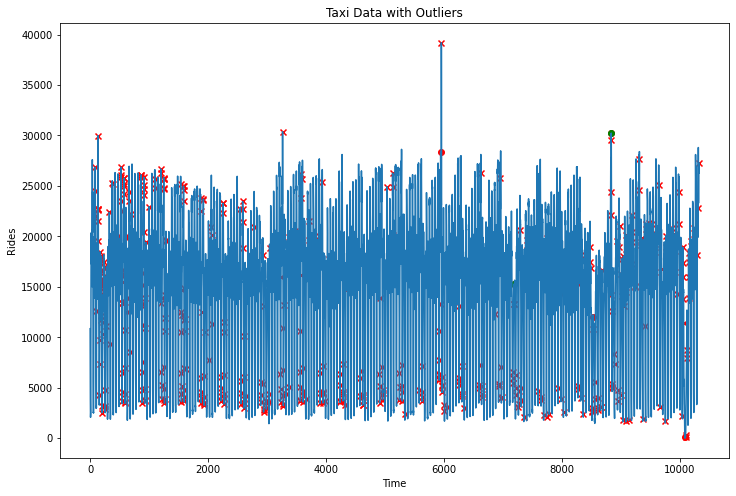

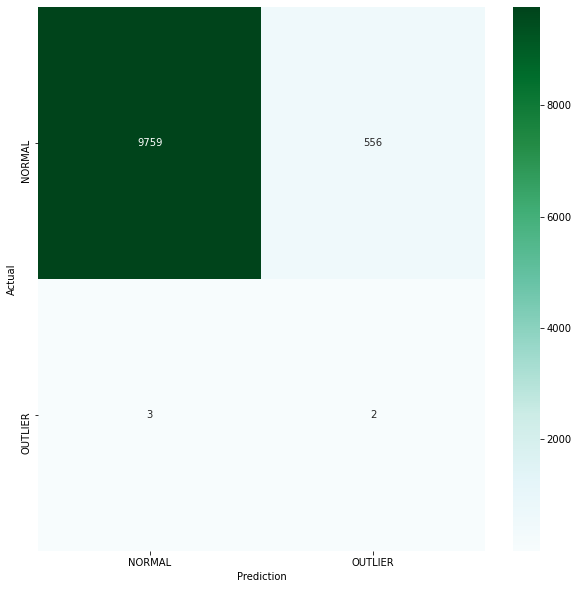

              precision    recall  f1-score   support

      NORMAL       1.00      0.95      0.97     10315
     OUTLIER       0.00      0.40      0.01         5

    accuracy                           0.95     10320
   macro avg       0.50      0.67      0.49     10320
weighted avg       1.00      0.95      0.97     10320



In [ ]:
evaluate_outliers(tes_df, tes_df['OUTLIER'], tes_df['PRED'])

## Predict

In [ ]:
model_tes.forecast(1)

2015-02-01    25015.622933
Freq: 30T, dtype: float64

# ARIMA
* Auto-Regressive Integrated Moving Average
* Integrated
  * Differencing to make time series stationary
  * Why stationary? Linear models make an assumption that data points are independent
  * Differencing removes the trend
* Auto-Regressive AR
  * Present depends on weighted sum of past values 
  * A prolonged pandemic can be thought of as a AR
  * When we difference a time series we may need to remove more trend
* Moving Average MA 
  * White noise or shocks gradually fade over time
  * A short pandemic can be thought of as a MA shock
  * When we difference a time series we need to add back some trend
* The terms can be found a number of ways:
  * Inspecting the ACF-PACF plots
    * I term found with Augmented-Dickey-Fuller test
    * PACF Plot -> For the AR term
    * ACF Plot -> For the MA term
  * Grid search with smallest AIC (Cost)
  * Library pmdarima.auto_arima


## Data Prep

In [ ]:
arima_df = taxi_df.copy()
arima_df = arima_df[['TIMESTAMP', 'VALUE']]
arima_df['TIMESTAMP'] = pd.to_datetime(arima_df.TIMESTAMP)
arima_df = arima_df.set_index('TIMESTAMP')
arima_df = arima_df.asfreq('30T')
arima_df['VALUE'] = arima_df.VALUE.astype('float32')
arima_df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=10320, freq='30T')

## Visualize

In [ ]:
@interact
def visualize_arima(ar=[0,1,2], diff=[0,1,2], ma=[0,1,2]):
  arima_viz = ARIMA(arima_df, order=(ar, diff, ma))
  fitted = arima_viz.fit()
  yhat = fitted.predict(start=(0 + diff), end=len(arima_df), typ='levels')

  plt.figure(figsize=(10, 8))
  plt.plot(arima_df, label='Data')
  plt.plot(yhat, color='orange', label='ARIMA')
  plt.xlim(pd.Timestamp('2014-11-01'), pd.Timestamp('2014-11-03'))
  plt.legend()
  plt.title('ARIMA Model')

interactive(children=(Dropdown(description='ar', options=(0, 1, 2), value=0), Dropdown(description='diff', opt…

## Model


In [ ]:
arima_model = ARIMA(arima_df, order=(2, 0, 2))
arima_fit   = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                10320
Model:                     ARMA(2, 2)   Log Likelihood              -87746.958
Method:                       css-mle   S.D. of innovations           1192.096
Date:                Tue, 21 Jul 2020   AIC                         175505.916
Time:                        15:55:57   BIC                         175549.367
Sample:                    07-01-2014   HQIC                        175520.601
                         - 01-31-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.514e+04    230.673     65.623      0.000    1.47e+04    1.56e+04
ar.L1.VALUE     1.6416      0.014    119.022      0.000       1.615       1.669
ar.L2.VALUE    -0.6953      0.013    -52.300      0.000      -0.721      -0.669
ma.L1.VALUE    -0.0863      0.017     -5.122      0.000      -0.119      -0.053
ma.L2.VALUE     0.1419      0.013     10.940      0.000       0.116       0.167
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1805           -0.2112j            1.1993           -0.0282
AR.2            1.1805           +0.2112j            1.1993            0.0282
MA.1            0.3041           -2.6371j            2.6546           -0.2317
MA.2            0.3041           +2.6371j            2.6546            0.2317
-----------------------------------------------------------------------------
"""

## Test

In [ ]:
start_index = 0
end_index   = len(arima_df)
forecast    = arima_fit.predict(start=start_index, end=end_index)
arima_df['PREDICTED'] = forecast
arima_df['ERROR']     = arima_df.PREDICTED - arima_df.VALUE
deviation             = arima_df.ERROR.std()
arima_df['LOWER']     = arima_df.PREDICTED - (1.96 * deviation)
arima_df['UPPER']     = arima_df.PREDICTED + (1.96 * deviation)
arima_df['OUTLIER']   = taxi_df['OUTLIER'].values
arima_df['PRED']      = np.where((arima_df.VALUE >= arima_df.LOWER) &
                                   (arima_df.VALUE <= arima_df.UPPER), 0, 1)

In [ ]:
arima_df.head()

,VALUE,PREDICTED,ERROR,LOWER,UPPER,OUTLIER,PRED
TIMESTAMP,,,,,,,
2014-07-01 00:00:00,10844.0,15137.569384,4293.569384,12799.207172,17475.931596,0,1
2014-07-01 00:30:00,8127.0,10969.889830,2842.889830,8631.527618,13308.252042,0,1
2014-07-01 01:00:00,6210.0,6600.990506,390.990506,4262.628293,8939.352718,0,0
2014-07-01 01:30:00,4656.0,5187.613507,531.613507,2849.251295,7525.975720,0,0
2014-07-01 02:00:00,3820.0,4128.872231,308.872231,1790.510019,6467.234443,0,0


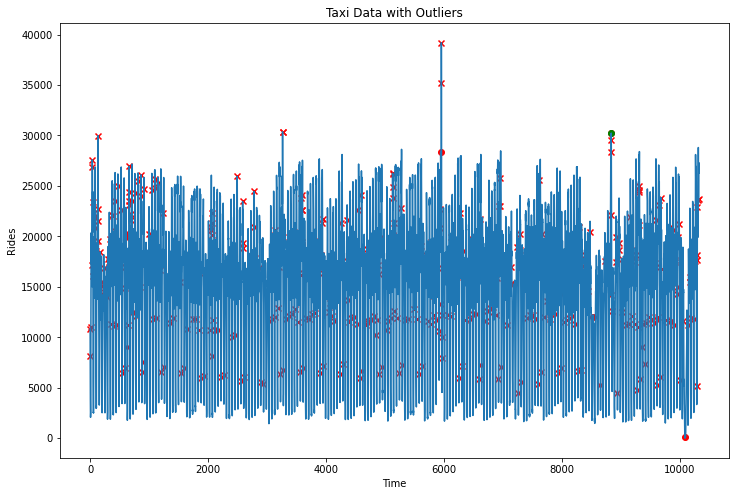

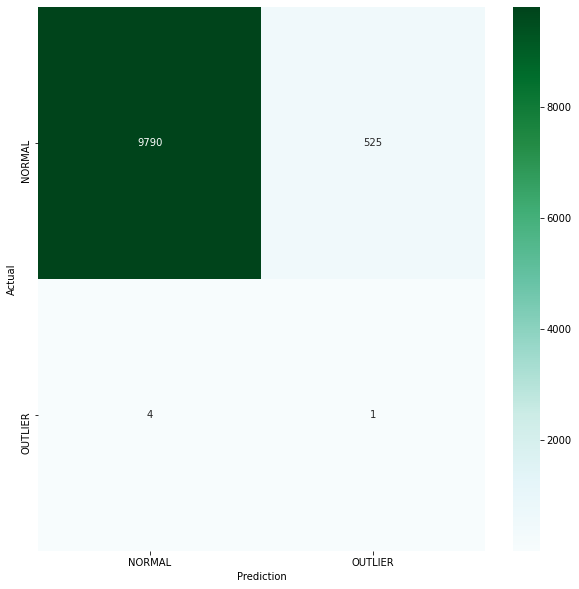

              precision    recall  f1-score   support

      NORMAL       1.00      0.95      0.97     10315
     OUTLIER       0.00      0.20      0.00         5

    accuracy                           0.95     10320
   macro avg       0.50      0.57      0.49     10320
weighted avg       1.00      0.95      0.97     10320



In [ ]:
evaluate_outliers(arima_df, arima_df['OUTLIER'], arima_df['PRED'])

## Predict
  * Next step forecast

In [ ]:
arima_fit.forecast(1)

(array([25270.15663177]),
 array([1192.09642355]),
 array([[22933.69057552, 27606.62268802]]))

# SARIMAX
* Introduces two additional features to the ARIMA model
  * Seasonality
    * Defined with parameters for AR, I, MA
    * Periodicity
  * Exogenous variables (Extra information)
* Mutliple seasonalities?  Consider using smallest periodicity.

## Data Prep

In [ ]:
sarimax_df = taxi_df.copy()
sarimax_df = sarimax_df[['TIMESTAMP', 'VALUE']]
sarimax_df['TIMESTAMP'] = pd.to_datetime(sarimax_df.TIMESTAMP)
sarimax_df = sarimax_df.set_index('TIMESTAMP')
sarimax_df = sarimax_df.asfreq('30T')
sarimax_df['VALUE'] = sarimax_df.VALUE.astype('float32')
sarimax_df.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=10320, freq='30T')

## Model

In [ ]:
sarimax_model = auto_arima(sarimax_df, 
  start_p=1, start_q=1, 
  start_P=1, start_Q=1,
  max_p=2, max_q=2, 
  max_P=2, max_Q=2, 
  D=0, max_D=48,
  seasonal=False, 
  stepwise=True, 
  suppress_warnings=True, 
  trace=True, 
  error_action='ignore')
sarimax_model.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=178970.638, BIC=178999.605, Time=2.835 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=211850.369, BIC=211864.853, Time=0.327 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=182446.453, BIC=182468.178, Time=0.868 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=199756.183, BIC=199777.908, Time=4.437 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=229915.915, BIC=229923.157, Time=0.156 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=175655.229, BIC=175691.438, Time=2.696 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=175829.172, BIC=175858.139, Time=1.106 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=175508.429, BIC=175551.880, Time=4.120 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=176653.490, BIC=176689.699, Time=3.921 seconds
Total fit time: 20.484 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10320
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -87748.214
Date:                Tue, 21 Jul 2020   AIC                         175508.429
Time:                        15:56:20   BIC                         175551.880
Sample:                             0   HQIC                        175523.114
                              - 10320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    764.0347     34.743     21.991      0.000     695.940     832.130
ar.L1          1.6477      0.011    151.225      0.000       1.626       1.669
ar.L2         -0.6986      0.011    -66.448      0.000      -0.719      -0.678
ma.L1         -0.0918      0.009     -9.686      0.000      -0.110      -0.073
ma.L2          0.1362      0.006     22.306      0.000       0.124       0.148
sigma2      1.424e+06   8547.628    166.604      0.000    1.41e+06    1.44e+06
===================================================================================
Ljung-Box (Q):                     1177.61   Jarque-Bera (JB):            209084.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.32
Prob(H) (two-sided):                  0.22   Kurtosis:                        25.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Test
* Control outliers with our alpha

In [ ]:
preds = sarimax_model.predict_in_sample(return_conf_int=True, alpha=0.01)
sarimax_df['PREDICTED'] = preds[0]
sarimax_df['ERROR']     = sarimax_df.PREDICTED - sarimax_df.VALUE
sarimax_df['LOWER']     = preds[1].T[0]
sarimax_df['UPPER']     = preds[1].T[1]
sarimax_df['OUTLIER']   = taxi_df['OUTLIER'].values
sarimax_df['PRED']      = np.where((sarimax_df.VALUE >= sarimax_df.LOWER) &
                                   (sarimax_df.VALUE <= sarimax_df.UPPER), 0, 1)

In [ ]:
sarimax_df

,VALUE,PREDICTED,ERROR,LOWER,UPPER,OUTLIER,PRED
TIMESTAMP,,,,,,,
2014-07-01 00:00:00,10844.0,14992.161965,4148.161965,-3284.586516,33268.910447,0,0
2014-07-01 00:30:00,8127.0,10960.157305,2833.157305,6665.311577,15255.003032,0,0
2014-07-01 01:00:00,6210.0,6580.537821,370.537821,3466.411084,9694.664557,0,0
2014-07-01 01:30:00,4656.0,5157.964400,501.964400,2073.303294,8242.625505,0,0
2014-07-01 02:00:00,3820.0,4093.061689,273.061689,1018.051404,7168.071974,0,0
...,...,...,...,...,...,...,...
2015-01-31 21:30:00,24670.0,23464.901210,-1205.098790,20391.055090,26538.747330,0,0
2015-01-31 22:00:00,25721.0,25048.681035,-672.318965,21974.834915,28122.527155,0,0
2015-01-31 22:30:00,27309.0,26010.906032,-1298.093968,22937.059912,29084.752152,0,0


In [ ]:
sarimax_df.OUTLIER

TIMESTAMP
2014-07-01 00:00:00    0
2014-07-01 00:30:00    0
2014-07-01 01:00:00    0
2014-07-01 01:30:00    0
2014-07-01 02:00:00    0
                      ..
2015-01-31 21:30:00    0
2015-01-31 22:00:00    0
2015-01-31 22:30:00    0
2015-01-31 23:00:00    0
2015-01-31 23:30:00    0
Freq: 30T, Name: OUTLIER, Length: 10320, dtype: int64

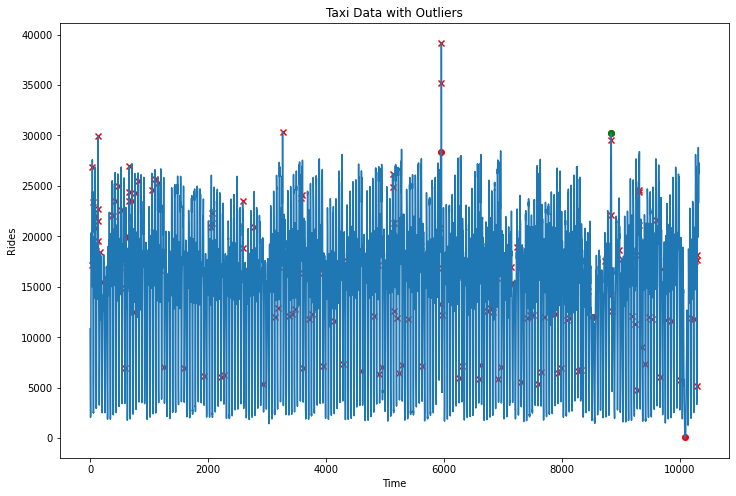

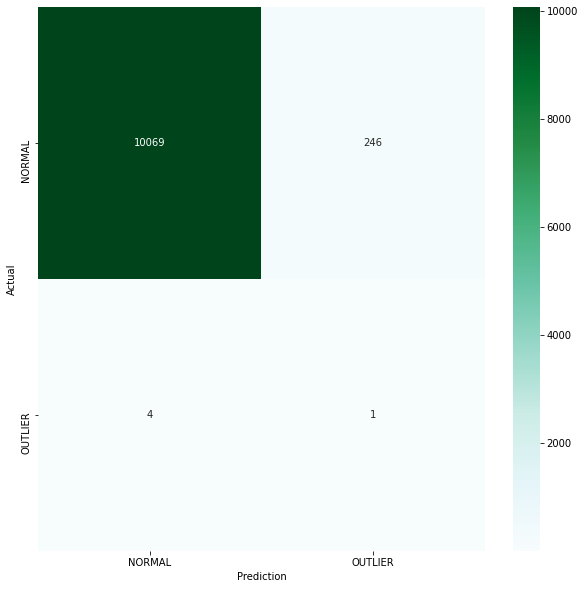

              precision    recall  f1-score   support

      NORMAL       1.00      0.98      0.99     10315
     OUTLIER       0.00      0.20      0.01         5

    accuracy                           0.98     10320
   macro avg       0.50      0.59      0.50     10320
weighted avg       1.00      0.98      0.99     10320



In [ ]:
evaluate_outliers(sarimax_df, sarimax_df['OUTLIER'], sarimax_df['PRED'])

## Predict
* Next step prediction

In [ ]:
sarimax_model.predict(1, return_conf_int=True, alpha=0.01)

(array([25294.60835848]), array([[22220.76223849, 28368.45447848]]))

# Prophet
* Time Series Library contributed by Facebook
* Available in Python & R
* Additive models with non-linear trends
* Multiple seasonality
* Holiday effects
* Robust missing data and shifts (changepoints)
* Expects two columns:
  * ds = timestamp or date
  * y = value

## Data Prep

In [ ]:
X_train_prophet = taxi_df.copy()
y_train_prophet = X_train_prophet['OUTLIER']
X_train_prophet = X_train_prophet.drop(columns=['OUTLIER'])
X_train_prophet.columns = ['ds', 'y']
X_train_prophet.head()

,ds,y
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


## Model

In [ ]:
def fit_prophet(df, interval_width = 0.99, changepoint_range = 0.8):
    pro = Prophet(daily_seasonality = True, 
                  yearly_seasonality = False, 
                  weekly_seasonality = True,
                  seasonality_mode = 'multiplicative', 
                  interval_width = interval_width,
                  changepoint_range = changepoint_range)
    model = pro.fit(df)
    forecast = model.predict(df)
    forecast['fact'] = df['y'].reset_index(drop = True)
    return forecast

In [ ]:
pred = fit_prophet(X_train_prophet)
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,fact
0,2014-07-01 00:00:00,13935.467743,2976.659799,22930.139284,13935.467743,13935.467743,0.038993,0.038993,0.038993,-0.056592,-0.056592,-0.056592,-0.095585,-0.095585,-0.095585,0.0,0.0,0.0,13146.828994,10844
1,2014-07-01 00:30:00,13937.157881,2211.449727,21293.861591,13937.157881,13937.157881,-0.053244,-0.053244,-0.053244,-0.145889,-0.145889,-0.145889,-0.092645,-0.092645,-0.092645,0.0,0.0,0.0,11903.875463,8127
2,2014-07-01 01:00:00,13938.848019,-234.069800,20218.929260,13938.848019,13938.848019,-0.156401,-0.156401,-0.156401,-0.246151,-0.246151,-0.246151,-0.089750,-0.089750,-0.089750,0.0,0.0,0.0,10507.787491,6210
3,2014-07-01 01:30:00,13940.538157,-106.122095,18128.875754,13940.538157,13940.538157,-0.271333,-0.271333,-0.271333,-0.358236,-0.358236,-0.358236,-0.086903,-0.086903,-0.086903,0.0,0.0,0.0,8946.530295,4656
4,2014-07-01 02:00:00,13942.228295,-2455.536964,16716.494651,13942.228295,13942.228295,-0.394764,-0.394764,-0.394764,-0.478874,-0.478874,-0.478874,-0.084110,-0.084110,-0.084110,0.0,0.0,0.0,7265.661525,3820


## Anomalies

In [ ]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [ ]:
pred = detect_anomalies(pred)
pred[pred.anomaly != 0]

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
208,2014-07-05 08:00:00,14287.016413,15896.380404,6689.042258,25010.015381,4682,-1,0.428672
209,2014-07-05 08:30:00,14288.706551,16892.707191,7153.535708,25522.971123,6248,-1,0.144932
210,2014-07-05 09:00:00,14290.396689,17515.771530,8153.250239,27293.454361,7454,-1,0.093809
232,2014-07-05 20:00:00,14327.579721,23947.990289,14279.256724,33046.093628,14140,-1,0.009848
233,2014-07-05 20:30:00,14329.269859,23796.791966,14753.549369,32785.961654,14477,-1,0.019103
...,...,...,...,...,...,...,...,...
10119,2015-01-27 19:30:00,14092.517237,20780.495609,11181.670704,29833.517489,10813,-1,0.034095
10120,2015-01-27 20:00:00,14092.252540,21114.604095,11327.972707,30499.779236,10419,-1,0.087242
10121,2015-01-27 20:30:00,14091.987843,21024.735253,12025.118401,30487.954165,10132,-1,0.186845
10122,2015-01-27 21:00:00,14091.723146,20545.362623,10891.747776,29986.343093,10566,-1,0.030830


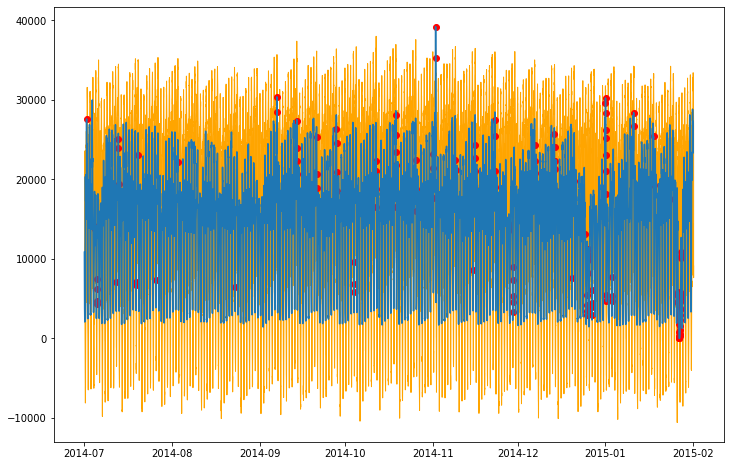

In [ ]:
def plot_prophet_anomalies(forecasted):
  plt.figure(figsize=(12,8))
  plt.fill_between(forecasted.ds, forecasted.yhat_lower, forecasted.yhat_upper, color='orange')
  plt.plot(forecasted.ds, forecasted.fact)
  outliers_df = forecasted[(forecasted.anomaly == 1) | (forecasted.anomaly == -1)]
  plt.scatter(outliers_df.ds, outliers_df.fact, color='red');
  

plot_prophet_anomalies(pred)

# Changepoint Detection
* https://arxiv.org/pdf/1801.00826.pdf

(<Figure size 864x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f99d5d02ba8>])

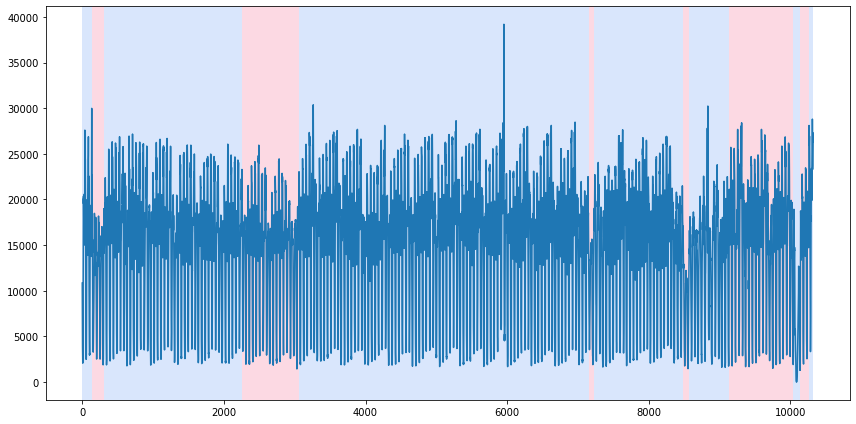

In [ ]:
algo = rpt.Pelt(model='rbf')
algo.fit(taxi_df[['VALUE']])
result = algo.predict(pen=10)
rpt.display(taxi_df.VALUE, result, figsize=(12,6))

In [ ]:
taxi_df.iloc[result[0:-1]]

,TIMESTAMP,VALUE,OUTLIER
145,2014-07-04 00:30:00,14395,0
305,2014-07-07 08:30:00,18998,0
2260,2014-08-17 02:00:00,18335,0
3060,2014-09-02 18:00:00,21395,0
7150,2014-11-26 23:00:00,15613,0
7225,2014-11-28 12:30:00,17025,0
8490,2014-12-24 21:00:00,12453,0
8565,2014-12-26 10:30:00,10994,0
9135,2015-01-07 07:30:00,18374,0
10030,2015-01-25 23:00:00,9964,0


# Time Series Augmentation
* Useful we have few data data points to learn from
* Increases robustness of our solution
* We can:
  * Add noise
  * Drift signal (introduce trend changes)
  * Reverse signal
  * Time warp (frequency changes)

In [ ]:
taxi_df.head()

,TIMESTAMP,VALUE,OUTLIER
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


In [ ]:
aug_df = taxi_df.copy()

In [ ]:
treatment = ['Drift', 'Reverse', 'AddNoise', 'TimeWarp', 'All']

@interact
def augment(treatment=treatment):
  if treatment == 'Drift':
    aug = Drift(max_drift=(0.1, 0.5))
  elif treatment == 'Reverse':
    aug = Reverse()
  elif treatment == 'AddNoise':
    aug = AddNoise(scale=0.1)
  elif treatment == 'TimeWarp':
    aug = TimeWarp()
  else:
    aug = (
        Drift(max_drift=(0.1, 0.5)) @ 0.5
        + Reverse() @ 0.5
        + AddNoise(scale=0.1) @ 0.5
        + TimeWarp() @ 0.5
    )

  X = aug_df.VALUE.to_numpy()
  X_aug = aug.augment(X)
  plt.plot(X, label='Original', alpha=0.5)
  plt.plot(X_aug, alpha=0.75, color='orange', label='Augmented')
  plt.legend()
  plt.title('Augmented Time Series')
  plt.show()

  X = aug_df.VALUE.to_numpy()
  X_aug = aug.augment(X)
  plt.plot(X[5800: 6100], label='Original')
  plt.plot(X_aug[5800: 6100], alpha=0.75, color='orange', label='Augmented')
  plt.legend()
  plt.title('Augmented Time Series -- Zoom')
  plt.show()



interactive(children=(Dropdown(description='treatment', options=('Drift', 'Reverse', 'AddNoise', 'TimeWarp', '…